In [1]:
from mujoco_py import load_model_from_path, MjSim, MjViewer
from mujoco_py import MjRenderContextOffscreen
import mujoco_py

from IPython.display import HTML, display
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import imageio
import base64
import types
import time
import glob
import cv2
import io

In [2]:
def reset_mocap_welds(sim):
    """Resets the mocap welds that we use for actuation.
    """
    if sim.model.nmocap > 0 and sim.model.eq_data is not None:
        for i in range(sim.model.eq_data.shape[0]):
            if sim.model.eq_type[i] == mujoco_py.const.EQ_WELD:
                sim.model.eq_data[i, :] = np.array(
                    [0., 0., 0., 1., 0., 0., 0.])
    sim.forward()
    
def save_video(frames, filename='video/mujoco.mp4', fps=60):
    writer = imageio.get_writer(filename, fps=fps)
    for f in frames:
        writer.append_data(f)
    writer.close()
    
def show_video(filname='video/mujoco.mp4'):
    mp4list = glob.glob(filname)
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
        
def show_image(img):
    #cv2.imshow("test", img)
    plt.figure(figsize = (16,9))
    plt.axis('off')
    plt.imshow(img)

In [3]:
model = load_model_from_path('make_urdf/ur5_robotiq.xml')
n_substeps = 20
sim = MjSim(model, nsubsteps=n_substeps)
viewer = MjViewer(sim)

Creating window glfw


In [4]:
arm_joint_list = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
gripper_joint_list = ['left_finger_joint', 'right_finger_joint']

str = ''
for joint_name in gripper_joint_list:
    str += "{} : {:.3f}, ".format(joint_name, sim.data.get_joint_qpos(joint_name))
print(str)

left_finger_joint : 0.000, right_finger_joint : 0.000, 


In [5]:
init_arm_pos = np.array([-np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, 0.0])
for joint_idx, joint_name in enumerate(arm_joint_list):
    sim.data.set_joint_qpos(joint_name, init_arm_pos[joint_idx])
    sim.data.set_joint_qvel(joint_name, 0.0)
reset_mocap_welds(sim)
    
# Move end effector into position.
gripper_target = np.array([0.0, 0.0, -0.1]) + sim.data.get_body_xpos('wrist_3_link')
gripper_rotation = np.array([1., 0., 1., 0.])
sim.data.set_mocap_pos('robot0:mocap', gripper_target)
sim.data.set_mocap_quat('robot0:mocap', gripper_rotation)
for _ in range(10):
    sim.step()
    sim.render(mode='window')

In [6]:
lookat_refer = sim.data.get_body_xpos('target_body_1')
viewer.cam.lookat[0] = lookat_refer[0]
viewer.cam.lookat[1] = lookat_refer[1]
viewer.cam.lookat[2] = lookat_refer[2]
viewer.cam.azimuth = -75
viewer.cam.elevation = -15
viewer.cam.distance = 1.5

In [59]:
print(sim.data.get_body_xpos('box_link'))

[0.    0.    0.435]


In [63]:
print(sim.data.get_body_xpos('target_body_1'))

[0.20104979 0.26113277 0.89476006]


In [64]:
0.8947 - 0.435

0.45970000000000005

In [18]:
def move_to_pos(pos=[0.0, 0.0, 0.63], quat=[0, 1, 0, 0], grasp=0.0):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('box_link') + np.array(pos)
    sim.data.mocap_quat[0] = np.array(quat)
    sim.data.ctrl[0] = grasp
    sim.data.ctrl[1] = grasp
    
    control_freq = 20
    control_timestep = 1. / control_freq
    cur_time = time.time()
    end_time = cur_time + control_timestep
#     for i in range(100):
    while cur_time < end_time:
        sim.step()
        cur_time += sim.model.opt.timestep
        sim.render(mode='window')
#         viewer.render()
#         time.sleep(0.1)
    diff_pos = np.linalg.norm(sim.data.mocap_pos[0] - sim.data.get_body_xpos('robot0:mocap'))
    diff_quat = np.linalg.norm(sim.data.mocap_quat[0] - sim.data.get_body_xquat('robot0:mocap'))
    if diff_pos + diff_quat > 1e-3:
        print('Failed to move to target position.')

def move_pos_diff(posdiff, quat=[0, 1, 0, 0], grasp=0.0):
    cur_pos = deepcopy(sim.data.mocap_pos[0]) - sim.data.get_body_xpos('box_link')
    target_pos = cur_pos + np.array(posdiff)
    return move_to_pos(target_pos, quat, grasp)


In [20]:
move_to_pos()

In [27]:
move_to_pos([0, 0.2, 0.85], grasp=0.0)
move_to_pos([0, 0.2, 0.63], grasp=0.0)
move_to_pos([0, 0.2, 0.63], grasp=1.0)
move_to_pos([0, 0.2, 0.85], grasp=1.0)

In [26]:
move_pos_diff([0.0, -0.4, 0])

In [38]:
sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.3])
sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

for i in range(3):
    print(sim.data.mocap_pos[0][2])
    print(sim.data.get_body_xpos('robot0:mocap')[2])
    sim.step()
    sim.render(mode='window')
    time.sleep(0.1)

print()
sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.15])
sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

for i in range(3):
    print(sim.data.mocap_pos[0])
    print(sim.data.get_body_xpos('robot0:mocap'))
    sim.step()
    sim.render(mode='window')
    time.sleep(0.1)

sim.step()
sim.render(mode='window')
time.sleep(0.1)


1.194784702734901
1.044784702734901
1.194784702734901
1.194784702734901
1.194784702734901
1.194784702734901

[-6.41153797e-18  2.00000000e-01  1.04478470e+00]
[-6.41153797e-18  2.00000000e-01  1.19478470e+00]
[-6.41153797e-18  2.00000000e-01  1.04478470e+00]
[-6.41153797e-18  2.00000000e-01  1.04478470e+00]
[-6.41153797e-18  2.00000000e-01  1.04478470e+00]
[-6.41153797e-18  2.00000000e-01  1.04478470e+00]


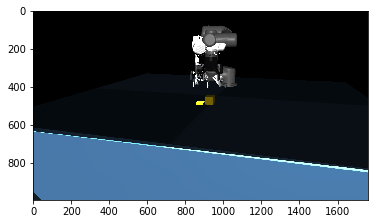

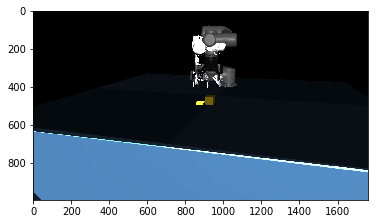

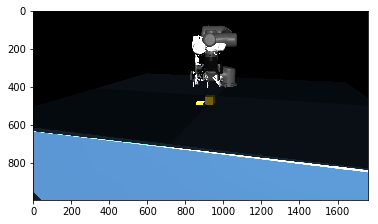

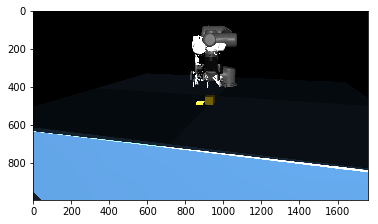

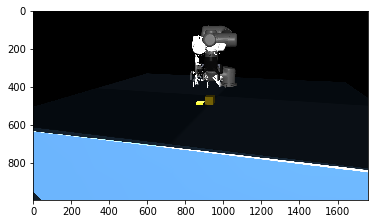

In [19]:
gripper_ctrl = -0.05
width, height = 64, 64

frames = []
cnt = 0
steps = 30 #0
for j in range(steps):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.3])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl
    
    sim.step()
    sim.render(mode='window')
#     time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
#         im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        viewer._set_mujoco_buffers()
        frames.append(img)
        plt.imshow(img)
        plt.show()

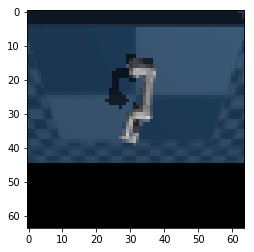

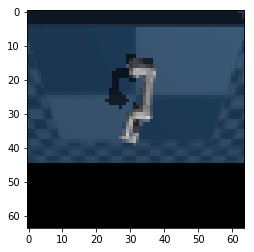

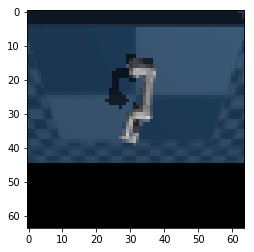

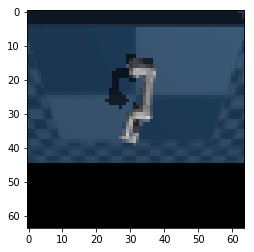

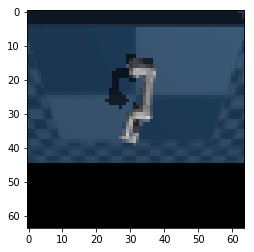

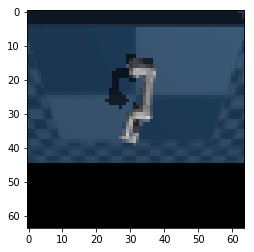

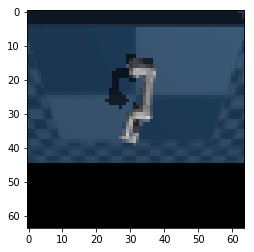

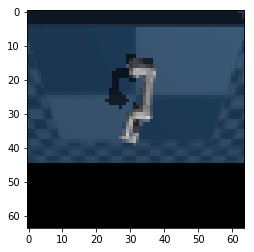

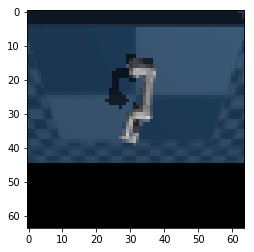

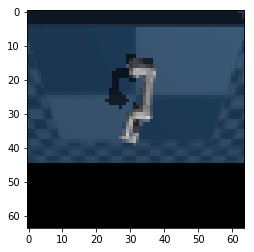

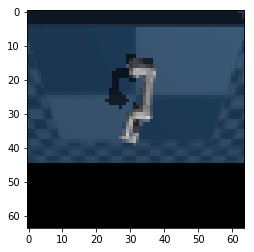

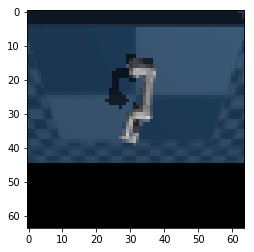

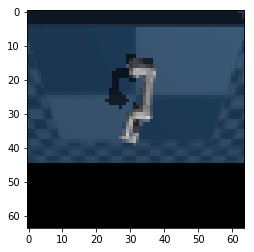

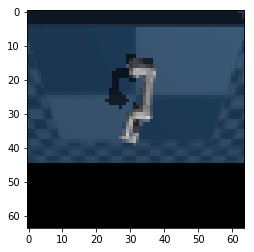

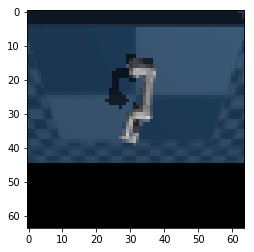

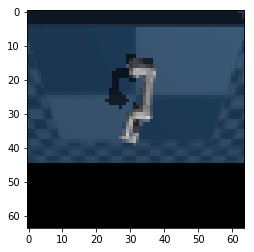

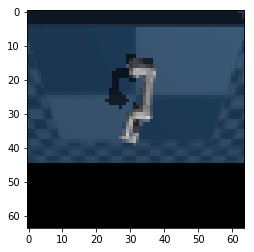

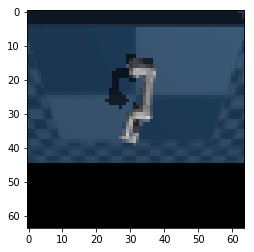

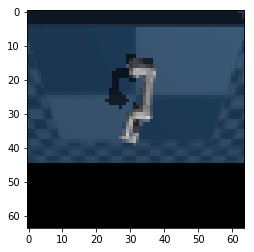

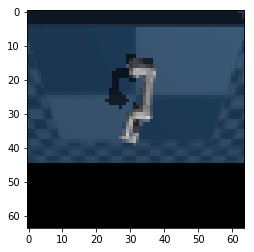

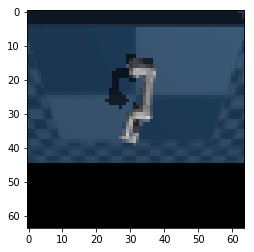

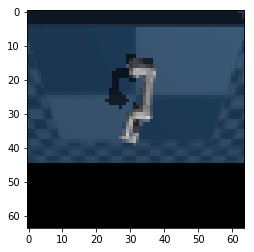

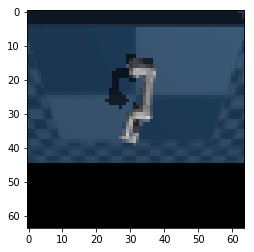

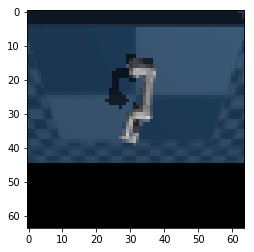

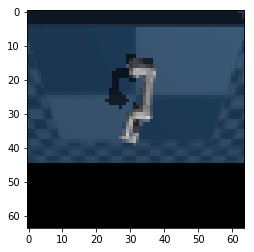

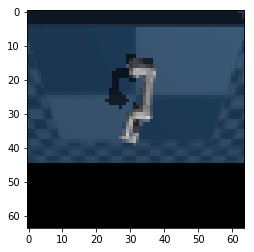

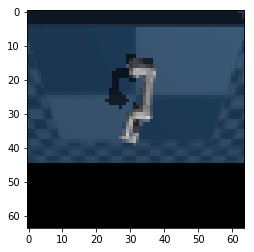

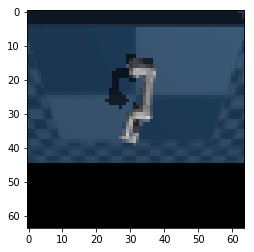

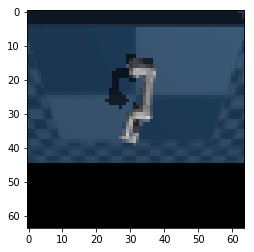

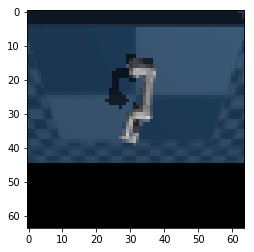

In [15]:
gripper_ctrl = -0.05
width, height = 64, 64

frames = []
cnt = 0
steps = 30 #0
for j in range(steps):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.3])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl
    
#     sim.step()
#     sim.render(mode='window')
#     time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.step()
        sim.render(mode="window")
    viewer._set_mujoco_buffers()
#     img = viewer._read_pixels_as_in_window()
    img = viewer.sim.render(width=width, height=height, mode='offscreen')
    img = viewer.sim.render(width=width, height=height, mode='offscreen')
    viewer._set_mujoco_buffers()
    plt.imshow(img)
    plt.show()
        
#         sim.render(mode='window')
#         viewer._set_mujoco_buffers()
#         im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
#         img = viewer._read_pixels_as_in_window()
#         viewer._set_mujoco_buffers()
#         frames.append(img)
#         plt.imshow(img)
#         plt.show()

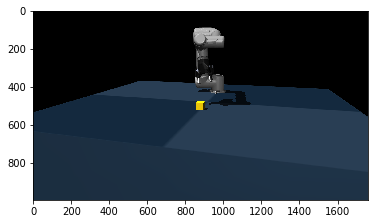

In [9]:
plt.imshow(frames[0])

In [11]:
gripper_ctrl = -0.05
width, height = 64, 64

frames = []
cnt = 0
steps = 300
for j in range(steps):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.3])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl
    
    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
#         viewer.render()
        sim.render(mode='window')
#         viewer._set_mujoco_buffers()
#         im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
#         img = viewer._read_pixels_as_in_window()
#         viewer._set_mujoco_buffers()
#         frames.append(img)

gripper_ctrl = -0.05
for j in range(steps):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.15])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
#         viewer.render()
        sim.render(mode='window')
#         viewer._set_mujoco_buffers()
#         im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
#         img = viewer._read_pixels_as_in_window()
#         viewer._set_mujoco_buffers()
#         frames.append(img)

In [1]:
gripper_ctrl = -0.05
width, height = 64, 64

frames = []
cnt = 0
steps = 300
for j in range(steps):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.3])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl
    
    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)
        
#######################################################
#######################################################

gripper_ctrl = -0.05
for j in range(steps):
    sim.data.mocap_pos[0] = sim.data.get_body_xpos('target_body_1') + np.array([0, 0, 0.15])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)

#######################################################
#######################################################

gripper_ctrl = 0.05
init_mocap_pos = deepcopy(sim.data.mocap_pos[0])

for j in range(steps):
    sim.data.mocap_pos[0] = init_mocap_pos
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl
        #sim.data.ctrl[gripper_idx] = gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)

#######################################################
#######################################################

gripper_ctrl = 0.05
init_mocap_pos = deepcopy(sim.data.mocap_pos[0])

for j in range(steps):
    sim.data.mocap_pos[0] = init_mocap_pos + np.array([0, 0, 0.001*j])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)

    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)

#######################################################
#######################################################

gripper_ctrl = 0.05
init_mocap_pos = deepcopy(sim.data.mocap_pos[0])

for j in range(steps):
    sim.data.mocap_pos[0] = init_mocap_pos + np.array([0.0007*j, 0, 0])
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)

    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)

#######################################################
#######################################################

gripper_ctrl = 0.05
init_mocap_pos = deepcopy(sim.data.mocap_pos[0])

for j in range(steps):
    init_mocap_pos[2] = max(init_mocap_pos[2] - j*0.0003, 1.1)
    sim.data.mocap_pos[0] = init_mocap_pos
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)
    
    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)

#######################################################
#######################################################

gripper_ctrl = -0.005
init_mocap_pos = deepcopy(sim.data.mocap_pos[0])

for j in range(steps):
    sim.data.mocap_pos[0] = init_mocap_pos
    sim.data.mocap_quat[0] = np.array([0, 1, 0, 0])

    for gripper_idx in range(len(gripper_joint_list)):
        cur_pos = sim.data.get_joint_qpos(gripper_joint_list[gripper_idx])
        sim.data.ctrl[gripper_idx] = cur_pos + gripper_ctrl

    sim.step()
    sim.render(mode='window')
    time.sleep(0.001)

    cnt += sim.model.opt.timestep/viewer._time_per_render
    while cnt > 0:
        cnt -= 1
        sim.render(mode='window')
        viewer._set_mujoco_buffers()
        im_state = viewer.sim.render(width=width, height=height, mode='offscreen')
        img = viewer._read_pixels_as_in_window()
        viewer._set_mujoco_buffers()
        frames.append(img)


NameError: name 'sim' is not defined

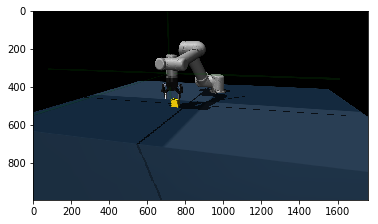

In [9]:
plt.imshow(img)

In [10]:
save_video(frames, 'video/mujoco.mp4', int(0.5/viewer._time_per_render))
show_video('video/mujoco.mp4')